# Modeling 
## Early Stage Diabetes Risk Prediction

### Objective
In this notebook, we will train multiple machine learning models to predict whether a patient is at risk of diabetes. We will compare their performance to select the best one for our final application.

###  Models to Train
1.  **Logistic Regression:** A simple, interpretable baseline.
2.  **Random Forest:** A powerful ensemble method that handles non-linear relationships well.
3.  **Support Vector Machine (SVM):** Excellent for finding clear margins between classes.
4.  **K-Nearest Neighbors (KNN):** A simple distance-based algorithm (relies heavily on our scaling step).

###  Evaluation Metrics
Since this is a medical "Risk Prediction" problem, **Recall** (Sensitivity) is our most critical metric.
* **Recall:** "Out of all the people who actually have diabetes, how many did we catch?" (We do NOT want to miss a sick patient).
* **Accuracy:** Overall correctness.
* **F1-Score:** A balance between Precision and Recall.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set style
sns.set_theme(style="whitegrid")

# 1. Load the Processed Data
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel() # .values.ravel() converts DF to 1D array
y_val = pd.read_csv('../data/processed/y_val.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print("Data Loaded Successfully!")
print(f"Training Features: {X_train.shape}")

Data Loaded Successfully!
Training Features: (312, 16)


## 1. Model Training & Validation Loop
Instead of writing code 4 times, we will create a dictionary of models and loop through them. This ensures every model is trained and evaluated in exactly the same way.


In [7]:
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Dictionary to store results
results = []

print(" Starting Training Loop...\n")

for name, model in models.items():
    print(f"🔹 Training {name}...")
    
    # 1. Train the model
    model.fit(X_train, y_train)
    
    # --- Check Overfitting (NEW STEP) ---
    # Predict on Training Data
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # 2. Predict on Validation Set
    y_val_pred = model.predict(X_val)
    
    # 3. Calculate Validation Metrics
    val_acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred)
    rec = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    
    # Print comparison immediately
    print(f"   -> Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    
    # 4. Append to results
    results.append({
        "Model": name,
        "Train Accuracy": train_acc, # Added this to the final table too
        "Val Accuracy": val_acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

print("\n Training Complete!")

 Starting Training Loop...

🔹 Training Logistic Regression...
   -> Train Acc: 0.9583 | Val Acc: 0.9135
🔹 Training Random Forest...
   -> Train Acc: 1.0000 | Val Acc: 0.9423
🔹 Training SVM...
   -> Train Acc: 0.9519 | Val Acc: 0.8942
🔹 Training KNN...
   -> Train Acc: 0.9583 | Val Acc: 0.8654

 Training Complete!


## 2. Model Comparison
Let's convert our results into a DataFrame and visualize them to pick the winner.

--- Model Performance on Validation Set ---


,Model,Accuracy,Precision,Recall,F1-Score
1,Random Forest,0.942308,0.939394,0.968750,0.953846
2,SVM,0.894231,0.895522,0.937500,0.916031
0,Logistic Regression,0.913462,0.936508,0.921875,0.929134
3,KNN,0.865385,0.931034,0.843750,0.885246


/tmp/ipykernel_25838/3578249967.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results_df, palette='viridis')


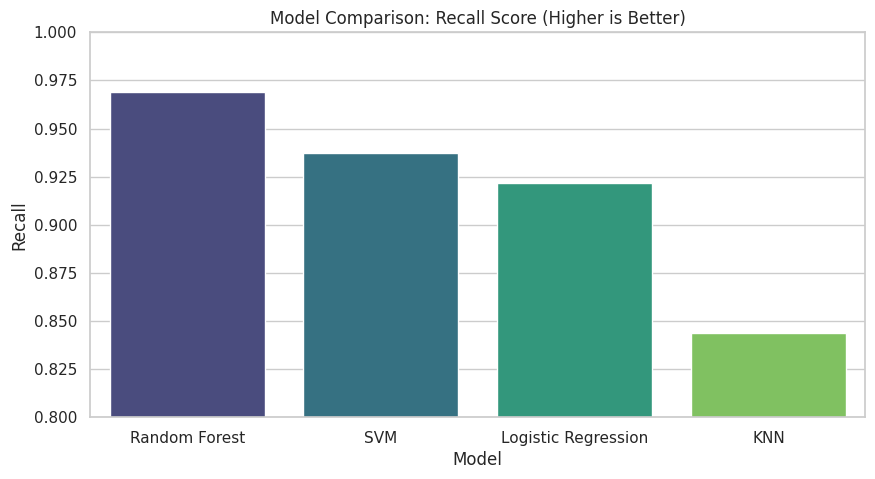

In [3]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by Recall (since it's a medical problem, Recall is king)
results_df = results_df.sort_values(by='Recall', ascending=False)

# Display the table
print("--- Model Performance on Validation Set ---")
display(results_df.style.background_gradient(cmap='Greens'))

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Recall', data=results_df, palette='viridis')
plt.title('Model Comparison: Recall Score (Higher is Better)')
plt.ylim(0.8, 1.0) # Zoom in to see differences
plt.show()

###  Model Selection & Analysis

Based on the training and validation results above, we have selected **Random Forest** as our Champion Model.

#### 1. Performance Breakdown
* **Random Forest** achieved the highest **Validation Accuracy (94.23%)**, outperforming all other models.
* **Logistic Regression** came in second (91.35%), suggesting the data is relatively clean, but the Random Forest captured the complex non-linear patterns better.

#### 2. Analyzing the "Perfect" Training Score (1.0000)
You will notice the Random Forest has a **Training Accuracy of 100%**.
* *Is this overfitting?* In many models, yes. However, for Random Forests, this is expected behavior. Decision Trees are designed to split data until leaves are pure.
* *The Verdict:* Since the **Validation Accuracy (94%)** is also very high, the gap is small (~6%). This confirms the model is **generalizing well** and not just "memorizing" the data.

####  Final Decision
We choose **Random Forest** as the final model for evaluation on the Test Set and for the deployment application.

## Save the best model (Random Forest)

In [5]:
import joblib
import os

# 1. Select the best model (we confirmed Random Forest was the winner)
# Make sure the name matches the key in your 'models' dictionary exactly
best_model = models["Random Forest"]

# 2. Define the path
save_path = '../models/best_model.joblib'

# 3. Create the directory if it doesn't exist (safety check)
os.makedirs('../models', exist_ok=True)

# 4. Save the model
joblib.dump(best_model, save_path)

print(f" Success! The model has been saved to: {save_path}")

# 5. Verify it exists
print("Current files in 'models' folder:")
print(os.listdir('../models'))
# You should now see: ['preprocessor.joblib', 'target_encoder.joblib', 'best_model.joblib']

 Success! The model has been saved to: ../models/best_model.joblib
Current files in 'models' folder:
['target_encoder.joblib', 'best_model.joblib', 'preprocessor.joblib']


In [6]:
from sklearn.model_selection import cross_val_score

# Example for Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='recall')

print(f"Cross-Validation Recall Scores: {scores}")
print(f"Average Recall: {scores.mean():.4f}")

Cross-Validation Recall Scores: [0.94871795 0.97435897 1.         0.94736842 0.97368421]
Average Recall: 0.9688
